In [2]:
%pip install torch torchvision transformers
%pip install wandb

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import json
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
from modules import UNet

class ImageCaptionDataset(Dataset):
    def __init__(self, img_dir, seg_dir, caption_file, transform=None):
        self.img_dir = img_dir
        self.seg_dir = seg_dir
        self.transform = transform
        with open(caption_file, 'r') as f:
            self.captions = json.load(f)
        self.filenames = list(self.captions.keys())

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        seg_name = 'segmented_' + img_name  #Adjusting name for segmented images

        img_path = os.path.join(self.img_dir, img_name)
        seg_path = os.path.join(self.seg_dir, seg_name)

        image = Image.open(img_path).convert('RGB')
        segmentation = Image.open(seg_path).convert('L')

        if self.transform:
            image = self.transform(image)
            segmentation = self.transform(segmentation)

        caption = self.captions[img_name]
        return image, segmentation, caption


# Transformations
transform = transforms.Compose([
    transforms.CenterCrop((512, 512)),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

/Users/princepatel/mit/school/6.8300/cv-finalproject/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np

def apply_canny_edge_detector(image, low_threshold=100, high_threshold=200):
    """
    Applies the Canny edge detector to a PyTorch tensor representing an image and returns a binary mask of the edges.

    Args:
        image_tensor (torch.Tensor): A tensor representing the image. Expected shape (B, H, W) where B is the size of batch.
        low_threshold (int): Lower threshold for the hysteresis process in Canny.
        high_threshold (int): Higher threshold for the hysteresis process in Canny.

    Returns:
        torch.Tensor: A binary mask where edges are 1 and non-edges are 0, as a tensor.
    """
    image = image * 255
    batch_np = image.numpy().astype(np.uint8)
    
    # Initialize an empty list to collect edge maps
    edge_maps = []
    
    # Process each image in the batch
    for image_np in batch_np:
        if image_np.shape[0] == 3:  # Assuming RGB images
            image_np = cv2.cvtColor(image_np.transpose(1, 2, 0), cv2.COLOR_RGB2GRAY)
        blurred_image = cv2.GaussianBlur(image_np, (3, 3), 0)
        edges = cv2.Canny(blurred_image, low_threshold, high_threshold)
        edge_maps.append(edges)
    
    # Convert list of arrays back to a tensor
    edge_tensor = torch.from_numpy(np.stack(edge_maps, axis=0)).unsqueeze(1).float() / 255
    return edge_tensor

class Params:
    def __init__(self):
        self.batch_size = 16
        self.learning_rate = 0.001
        self.epochs = 10

In [5]:
from transformers import BertModel, BertTokenizer

class DiffusionModel(nn.Module):
    def __init__(self, beta_start, beta_end, steps):
        super(DiffusionModel, self).__init__()
        # Networks definition
        self.delta_network = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        self.recovery_network = UNet(c_in=1, c_out=3, time_dim=256, device="cpu") 
        self.beta_t = torch.linspace(beta_start, beta_end, steps=steps)
        self.alpha_t = torch.cumprod(1 - self.beta_t, dim=0)

        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



    def compute_delta(self, text_features, t):
        # Compute the delta value based on text features and timestep
        delta_scale = self.delta_network(text_features).squeeze()
        return delta_scale

    def forward_pass(self, m, captions, t):
        inputs = self.bert_tokenizer(captions, return_tensors="pt", padding=True, truncation=True)
        outputs = self.bert_model(**inputs)
        text_embed = outputs.last_hidden_state[:, 0, :]

        alpha_t = self.alpha_t[t]
        one_minus_alpha_t = 1 - alpha_t

        # Compute delta
        delta = self.compute_delta(text_embed, t)

        # Generate noise
        m = m.float()  # Convert m to float
        delta = delta.float() 
        weighted_noise = torch.randn_like(m) * delta[0]

        # Compute the next timestep value
        x_t = m + (1 - m)*(torch.sqrt(alpha_t) * m + torch.sqrt(one_minus_alpha_t) * weighted_noise)
        return x_t

    def reverse_pass(self, x_t, m, t):
        # Compute recovery parameters
        t = torch.tensor(t, dtype=torch.float32)
        recovery_params = self.recovery_network(x_t, t)
        
        x_0 = 1 / torch.sqrt(self.alpha_t[t]) * (x_t - recovery_params * (1-m))
        return x_0
    
    def diffusion_loss(x_t, x_t1_pred, m):
        return ((x_t1_pred - x_t) ** 2 * (1 - m)).mean()

In [44]:
import wandb
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader

# Setup
T = 1000  # Total number of diffusion steps


n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
num_epochs = 10

# Initialize W&B
# wandb.init(project='image_captioning_with_diffusion_models', entity='michaelpeng72', config={
#     "epochs": num_epochs,
#     "batch_size": 16,
#     "learning_rate": 1e-4,
#     "n_splits": n_splits,
#     "shuffle": True,
#     "random_state": 42
# })

# config = wandb.config
config = Params()

full_dataset = ImageCaptionDataset('datasets/images', 'datasets/segmented', 'datasets/map.json', transform=transform)

for fold, (train_idx, valid_idx) in enumerate(kf.split(full_dataset)):
    print(f"Starting Fold {fold+1}/{n_splits}")
    # wandb.init(project='image_captioning_with_diffusion_models', entity='michaelpeng72', group="Experiment-X", job_type=f"Fold-{fold+1}", reinit=True)

    # Data loaders
    train_subset = torch.utils.data.Subset(full_dataset, train_idx)
    valid_subset = torch.utils.data.Subset(full_dataset, valid_idx)
    train_loader = DataLoader(train_subset, batch_size=config.batch_size, shuffle=True)
    valid_loader = DataLoader(valid_subset, batch_size=config.batch_size, shuffle=False)

    # Initialize model and optimizer
    model = DiffusionModel(beta_start=0.0001, beta_end=0.02, steps=1000)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    # Training
    model.train()
    for epoch in range(config.epochs):
        train_loss = 0
        for images, segmentations, captions in train_loader:
            m = apply_canny_edge_detector(images)
            t = torch.randint(0, T, (1,)).item()

            # Forward diffusion process
            noised_images = model.forward_pass(m, captions, t)
            print(noised_images.shape)
            # Reverse diffusion process
            recovered_images = model.reverse_pass(noised_images, m, t)

            # Calculate loss
            loss = model.diffusion_loss(images, recovered_images, m)
            train_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        # wandb.log({"Train Loss": train_loss})

        # Validation
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for images, segmentations, captions in valid_loader:
                m = apply_canny_edge_detector(segmentations)
                t = torch.randint(0, T, (1,)).item()
                
                # Same forward and reverse pass for validation
                noised_images = model.forward_pass(images, m, captions, t)
                recovered_images = model.reverse_pass(noised_images, m, captions, t)

                # Calculate validation loss
                loss = model.diffusion_loss(images, recovered_images, m)
                valid_loss += loss.item()

        valid_loss /= len(valid_loader)
        # wandb.log({"Validation Loss": valid_loss})
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")
        
    # wandb.finish()


Starting Fold 1/5


/Users/princepatel/mit/school/6.8300/cv-finalproject/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


torch.Size([16, 1, 512, 512])


: 

In [ ]:
#save the model to ../models
torch.save(model.state_dict(), 'models/diffusion_model.pth')

In [ ]:
#load model from ../models
model = DiffusionModel()
model.load_state_dict(torch.load('models/diffusion_model.pth'))

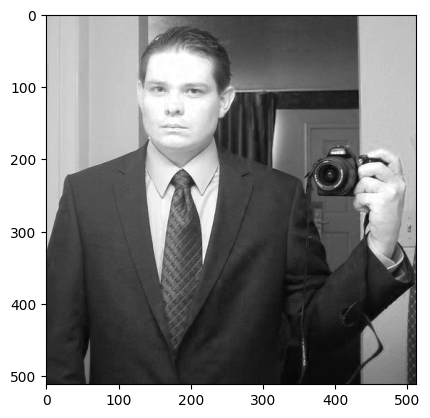

tensor([[[0.7725, 0.7765, 0.7686,  ..., 0.7490, 0.7529, 0.7490],
         [0.7765, 0.7765, 0.7686,  ..., 0.7451, 0.7412, 0.7373],
         [0.7765, 0.7804, 0.7725,  ..., 0.7451, 0.7373, 0.7373],
         ...,
         [0.1294, 0.1294, 0.1294,  ..., 0.1451, 0.1529, 0.1647],
         [0.1294, 0.1294, 0.1294,  ..., 0.1412, 0.1647, 0.1843],
         [0.1333, 0.1294, 0.1333,  ..., 0.1686, 0.1765, 0.2000]],

        [[0.6510, 0.6549, 0.6471,  ..., 0.6314, 0.6353, 0.6314],
         [0.6549, 0.6549, 0.6471,  ..., 0.6275, 0.6235, 0.6196],
         [0.6549, 0.6588, 0.6510,  ..., 0.6275, 0.6196, 0.6196],
         ...,
         [0.0706, 0.0706, 0.0706,  ..., 0.1333, 0.1333, 0.1451],
         [0.0745, 0.0745, 0.0745,  ..., 0.1294, 0.1451, 0.1686],
         [0.0745, 0.0784, 0.0745,  ..., 0.1529, 0.1608, 0.1843]],

        [[0.4392, 0.4431, 0.4353,  ..., 0.4824, 0.4863, 0.4824],
         [0.4431, 0.4431, 0.4353,  ..., 0.4784, 0.4745, 0.4706],
         [0.4431, 0.4471, 0.4392,  ..., 0.4784, 0.4706, 0.

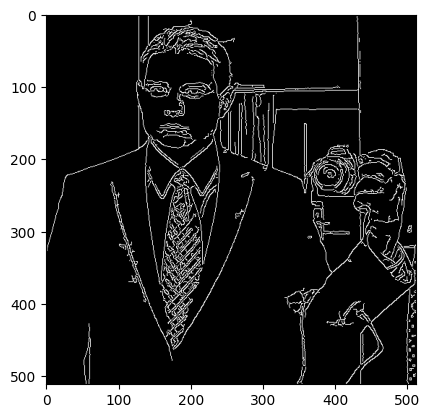

In [9]:
import matplotlib.pyplot as plt

example_segmented =  Image.open('datasets/images/COCO_val2014_000000000459.jpg').convert('RGB')
example_segmented = transform(example_segmented)

plt.imshow(example_segmented[0], cmap='gray')
plt.show()
print(example_segmented)
# m = apply_sobel_operator(example_segmented)
m = apply_canny_edge_detector(example_segmented, 10, 110)

#plot m
plt.imshow(m[0][0].numpy(), cmap='gray')
plt.show()